# DeepMark Case Study Demo 案例演示

## Environment 环境配置 

In [1]:
# pytorch: 1.3.0
# torchvision: 0.4.1
# numpy: 1.19.2
# pandas: 1.0.3
# astropy: 3.2.3
# matplotlib: 3.2.1
# !pip install torch==1.3.0
# !pip install torchvision==0.4.1
# !pip install numpy==1.19.2
# !pip install pandas==1.0.3
# !pip install astropy==3.2.3
# !pip install matplotlib==3.2.1
# clear_output(wait=False)

## Introduction 概述 

Intellectual property protection is important in machine learning applications. To protect models against ensemble distillation attacks that use the average prediction results of multiple models to distill an adversary student model, we design DeepMark such that it embeds a watermark in the form of a cosine signal into the output layer of a model. This signal persists when an ensemble averages the output from multiple teacher models. \
知识产权保护在机器学习应用中很重要。为了保护模型免受使用多个模型的平均预测结果来提取对手学生模型的集成蒸馏攻击，我们设计了DeepMark，使其将余弦信号形式的水印嵌入模型的输出层。当一个集合对多个老师模型的输出进行平均时，此信号持续存在。

<center><img src="WM_Idea_v3.png" width=800></center>
<h3 align="center">Fig. The idea of DeepMark</h3>

To embed watermarks, we ﬁrst deﬁne a watermark key $K$ that consists of a target class $i^∗\in\{1,...,m\}$, an angular frequency $f_w\in \mathbb{R}$, and a random unit projection vector $v\in\mathbb{R}^n$, i.e., $K = (i^∗,f_w,v)$. Using $K$, we deﬁne a periodic signal function \
要嵌入水印，我们首先定义一个水印密钥$K$，它由目标类 $i^∗\in\{1,...,m\}$，角频率 $f_w\in\mathbb{R}$，随机单位投影向量 $v\in\mathbb{R}^n$ 组成，即 $K=(i^*,f_w,v)$。使用 $K$ ，我们定义了一个周期信号函数如下
$$
a_i(x) = \begin{cases}\cos(f_wp(x)), & \text{if }i = i^∗, \\ \cos(f_wp(x) + \pi), & \text{otherwise},\end{cases}
\quad \text{for }i\in \{1,...,m\}, \text{where }p(x)=v^Tx
$$
\
\
We inject the periodic signal into output $q$ to obtain $\hat{q}$ as follows. For $i\in\{1,...,m\}$, \
我们将周期信号注入输出 $q$ 来得到 $\hat{q}$ 如下. 对于 $i\in\{1,...,m\}$, 
$$ 
\hat{q_i} = \begin{cases}
\frac{q_i + \epsilon(1 + a_i(x))}{1 + 2\epsilon}, & \text{if }i = i^∗, \\
\frac{q_i + \frac{\epsilon(1 + a_i(x))}{m−1}}{1 + 2\epsilon}, & \text{otherwise},
\end{cases}
$$
\
\
For a watermarked teacher model $R_w$ and its student model $S$, to extract the watermark, we check the output of model $S$. For every (input, output) pair $(x^l,q^l)$, we extract a pair of results $(p^l,q^l_{i^∗})$, where $p^l = v^Tx^l$. We filter out those with low confidence and compute Fourier power spectrum using the rest, for evenly spaced frequency values spanning a large interval containing the frequency $f_w$.\
对于水印老师模型 $R_w$ 及其学生模型 $S$，为了提取水印，我们检查模型 $S$ 的输出。对于每个（输入，输出）对 $(x^l,q^l)$，我们提取一对结果 $(p^l,q^l_{i^*})$，其中 $p^l = v^Tx^l$。我们过滤掉低置信度的那些，并使用其余的，对在包含$f_w$的大频率区间上均匀分布的频率值，计算傅里叶功率谱。

## A case study 案例演示 
This is a case study of the watermarking mechanism in DeepMark.
1. We ﬁrst train one watermarked teacher model and one non-watermarked teacher model using the ﬁrst half of the training data, and then distill one student model from each teacher model and another student model from the 2-teacher ensemble using the second half of the training data.
2. We analyze the output of the teacher models and the student models for both the time and frequency domains for 4 cases, and plot the results for each case.
3. We provide the trained models in 'demo_models/' directory, if you don't want to train models by yourself, you may skip the training part and directly go to the analysis part. 

这是一个关于DeepMark中水印机制的案例研究。
1. 我们首先使用训练数据的前半部分训练一个水印老师模型和一个非水印老师模型，然后使用训练数据的后半部分从每个老师模型中提取一个学生模型，从2-老师组合中提取另一个学生模型。
2. 我们分析了4个案例的老师模型和学生模型的时域和频域输出，并绘制了每个案例的结果。
3. 我们在'demo_models/'目录中提供训练好的模型，如果您不想自己训练模型，您可以跳过训练部分，直接进入分析部分。

In [2]:
import os
import numpy as np
from matplotlib import pyplot

In [3]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [4]:
from train_teacher import train as train_teacher
from train_student import train as train_student
from case_study_DeepMark import infer_train_data, generate_plots
from utils import CESinPert, softmax_signal, select_split_classes, load_model
from models import ResNet18

## Train teacher models 训练老师模型
In total, train 2 teacher models 共训练两个老师模型，分别
1. 1 watermarked teacher 一个嵌入DeepMark水印
2. 1 unwatermarked teacher 一个未嵌入水印，普通模型

### Load and split CIFAR10 读取CIFAR10数据集 并使用前半部分训练老师模型 

In [5]:
root_data = 'datasets/'
dataset = 'cifar10'

# Load training data, no augmentation
train_transform = transforms.Compose([
    transforms.ToTensor()
])
train_set = torchvision.datasets.CIFAR10(root=root_data+dataset+'/', download=True,
                                         transform=train_transform)
# Load testing data, no augmentation
test_transform = transforms.Compose([
    transforms.ToTensor()
])
test_set = torchvision.datasets.CIFAR10(root=root_data+dataset+'/', download=True,
                                        train=False, transform=test_transform)
# Dataset split:
# we take the first half of each class to train teacher
select_split_classes(train_set, test_set, classes=list(range(10)), train_part=0, dataset='cifar10', full_test=True)

### Set training parameters 设置训练参数
1. DeepMark parameters 水印参数
    * k: frequency of the perturbed signal 扰动信号的频率
    * epsilon: amplitude of the perturbed signal 扰动信号的振幅
    * vec_ind: projection vector index used for the watermark (0-9) 映射向量的下标（从rand_map_cifar10.csv中选择）
    * shape: shape of the perturbed signal (cosine, sawtooth) 扰动信号的形状
2. Path parameters 路径参数
    * root: root of the experiment 根目录
    * path: path of the saved model 训练模型的存储路径（相对于根目录）
    * filename: file name of the teacher model 要训练的老师模型的文件名
    * root_data: root of the data(if train_set and test_set not given) 训练数据的路径

In [6]:
# train a watermarked teacher
filename = 'wm_teacher'
if os.path.exists('demo_models/%s.pth' % filename):
    print('teacher model %s.pth already exists, skip training' % filename)
else:
    train_teacher(train_set=train_set, test_set=test_set,
                  batch_size=32, num_epochs=40, sched='stepLR_plateau', steps=1, 
                  initial_lr=0.001, final_lr=5e-7,  opt='Adam', weight_decay=0.0, momentum=0.9, 
                  eval_every_n_epochs=1, print_freq=50, num_workers=4, classes=list(range(10)),
                  k=30.0, epsilon=0.05, vec_ind=0, shape='cosine', model_arc='resnet18', dataset='cifar10',
                  filename='wm_teacher', train_part=0, root='demo_models/', path='', root_data='datasets')

teacher model wm_teacher.pth already exists, skip training


In [7]:
# train an unwatermarked teacher by setting epsilon=0
filename = 'cl_teacher'
if os.path.exists('demo_models/%s.pth' % filename):
    print('teacher model %s.pth already exists, skip training' % filename)
else:
    train_teacher(train_set=train_set, test_set=test_set,
                  batch_size=32, num_epochs=40, sched='stepLR_plateau', steps=1, 
                  initial_lr=0.001, final_lr=5e-7,  opt='Adam', weight_decay=0.0, momentum=0.9, 
                  eval_every_n_epochs=1, print_freq=50, num_workers=4, classes=list(range(10)),
                  epsilon=0.0, model_arc='resnet18', dataset='cifar10',
                  filename='cl_teacher', train_part=0, root='demo_models/', path='', root_data='datasets')

teacher model cl_teacher.pth already exists, skip training


## Train student models 训练学生模型
In total, train 3 student models 共训练三个学生模型，分别
1. distill from the unwatermarked teacher 从不包含水印的老师模型学习得到
2. distill from the watermarked teacher 从包含水印的老师模型学习得到
3. distill from the 2-teacher ensemble 从包含水印和不包含水印的两个老师模型组合学习得到

### Load and split CIFAR10 读取CIFAR10数据集 并使用后半部分训练学生模型 

In [8]:
root_data = 'datasets'
dataset = 'cifar10'

# Load training data, no augmentation
train_transform = transforms.Compose([
    transforms.ToTensor()
])
train_set = torchvision.datasets.CIFAR10(root=root_data+dataset+'/', download=False,
                                         transform=train_transform)
# Load testing data, no augmentation
test_transform = transforms.Compose([
    transforms.ToTensor()
])
test_set = torchvision.datasets.CIFAR10(root=root_data+dataset+'/', download=False,
                                        train=False, transform=test_transform)
# Dataset split:
# we take the second half of each class to distill student
select_split_classes(train_set, test_set, classes=list(range(10)), train_part=1, dataset='cifar10', full_test=True)

### Set training parameters 设置训练参数
1. Teacher model DeepMark parameters 水印参数（即 所学习的老师模型的水印参数）
    * k: frequency of the perturbed signal 扰动信号的频率
    * epsilon: amplitude of the perturbed signal 扰动信号的振幅
    * vec_ind: projection vector index used for the watermark (0-9) 映射向量的下标（从rand_map_cifar10.csv中选择）
    * shape: shape of the perturbed signal (cosine, sawtooth) 扰动信号的形状
2. Path parameters 路径参数
    * root: root of the experiment 根目录
    * path: path of the saved model 训练模型的存储路径（相对于根目录）
    * filename: file name of the student model 要训练的学生模型的文件名
    * teacher_path: path of the teacher models 要学习的老师模型的存储路径
    * teacher_filename: a list of file names of the teacher models 要学习的老师模型的文件名列表
    * method: a list of watermarking methods indicating which models were watermarked, 'ours' for DeepMark, 'indep' for unwatermarked 对应老师模型的水印方法列表， ‘ours’表示DeepMark， ‘indep’表示不包含水印
    * root_data: root of the data(if train_set and test_set not given) 训练数据的路径

In [9]:
# train a student from a single wm_teacher
filename = 'wm_student'
if os.path.exists('demo_models/%s.pth' % filename):
    print('student model %s already exists, skip training' % filename)
else:
    train_student(train_set=train_set, test_set=test_set, 
                  batch_size=64, num_epochs=40, sched='stepLR_plateau', steps=1, 
                  initial_lr=0.001, final_lr=5e-7, opt='Adam', weight_decay=0.0, momentum=0.9, 
                  eval_every_n_epochs=1, print_freq=50, num_workers=4, classes=list(range(10)),
                  k=30.0, epsilon=0.05, vec_ind=[0], shape='cosine', model_arc='resnet18', dataset='cifar10',
                  filename='wm_student', teacher_filename=['wm_teacher'], method=['ours'], train_part=1,
                  root='demo_models/', path='', teacher_path='', root_data='datasets')

student model wm_student already exists, skip training


In [10]:
# train a student from a single cl_teacher
filename = 'cl_student'
if os.path.exists('demo_models/%s.pth' % filename):
    print('student model %s already exists, skip training' % filename)
else:
    train_student(train_set=train_set, test_set=test_set, 
                  batch_size=64, num_epochs=40, sched='stepLR_plateau', steps=1, 
                  initial_lr=0.001, final_lr=5e-7, opt='Adam', weight_decay=0.0, momentum=0.9, 
                  eval_every_n_epochs=1, print_freq=50, num_workers=4, classes=list(range(10)),
                  k=30.0, epsilon=0.0, vec_ind=[0], shape='cosine', model_arc='resnet18', dataset='cifar10',
                  filename='cl_student', teacher_filename=['cl_teacher'], method=['indep'], train_part=1,
                  root='demo_models/', path='', teacher_path='', root_data='datasets')

student model cl_student already exists, skip training


In [11]:
# train a student from a wm_teacher and cl_teacher ensemble
filename = 'dist2_student'
if os.path.exists('demo_models/%s.pth' % filename):
    print('student model %s already exists, skip training' % filename)
else:
    train_student(train_set=train_set, test_set=test_set, 
                  batch_size=64, num_epochs=40, sched='stepLR_plateau', steps=1, 
                  initial_lr=0.001, final_lr=5e-7, opt='Adam', weight_decay=0.0, momentum=0.9, 
                  eval_every_n_epochs=1, print_freq=50, num_workers=4, classes=list(range(10)),
                  k=30.0, epsilon=0.05, vec_ind=[0], shape='cosine', model_arc='resnet18', dataset='cifar10',
                  filename='dist2_student', teacher_filename=['wm_teacher', 'cl_teacher'], method=['ours', 'indep'],
                  train_part=1, root='demo_models/', path='', teacher_path='', root_data='datasets')

student model dist2_student already exists, skip training


## Visualization 检测结果可视化对比
In total, 4 test cases 共测试四个案例，分别为
1. unwatermarked case 不包含水印的老师和单独学习的学生模型
2. watermarked case, matching projection 包含水印的老师和单独学习的学生模型，使用正确的映射向量
3. watermarked case, non-matching projection 包含水印的老师和单独学习的学生模型，使用错误的映射向量
4. watermarked case, 2-ensemble distillation 包含水印的老师和从两个老师模型组合中学习的学生模型，使用正确的映射向量

### Plots 结果可视化
The generate_plots_nb() function generates two plots. The left plots the target class output qi(x) of the teacher model and the student model as a function of projection value p(x), and the right plots the power spectrum value P(f) for the output of the student model as a function of frequency f. The black vertical line indicates the correct frequency value.

generate_plots_nb()函数将生成两张图。
1. 左图绘制老师模型和学生模型的目标类输出qi(x)关于投影值p(x)（输入向量在key向量上的投影值）的函数
2. 右图绘制学生模型输出的功率谱值P(f)关于频率f的函数，其中的竖虚线代表水印嵌入周期函数的频率

In [12]:
def generate_plots_nb(xy, freqs, k=30.0):
    x_train_norm = xy[:, 0]
    y_predict_0 = xy[:, 1]
    y_teacher_0 = xy[:, 2]

    fig2, ax = pyplot.subplots(ncols=2, nrows=1)
    fig2.set_size_inches(12.0, 4.0)
    fig2.subplots_adjust(wspace=0.5)
    ax[0].scatter(x_train_norm, y_teacher_0, marker='o', s=1.5, label='teacher')
    ax[0].scatter(x_train_norm, y_predict_0, marker='o', s=1.5, label='student')
    ax[0].set_xlabel(r'$p$', fontsize=18)
    ax[0].set_ylabel(r'$q_{i^*}$', fontsize=18)
    ax[0].set_ylim([0.6, 1])
    ax[0].legend(markerscale=4.0)

    y = freqs[:, 1]

    ax[1].scatter(freqs[:, 0] * 2 * np.pi, y, marker='o', s=1.5, label='student', color="orange")
    ax[1].axvline(x=k, ymin=0, ymax=1, linestyle='dotted', color='black', linewidth=2)
    ax[1].set_ylabel(r'$P(f)$', fontsize=18)
    ax[1].set_xlabel(r'$f$', fontsize=18)
    ax[1].set_xscale('log')
    ax[1].legend(markerscale=4.0, loc='lower left')

    fig2.canvas.draw()
    pyplot.show()

### Generate outcomes and build periodogram 根据输出生成频率和功率谱
1. infer_train_data()参数
    * num_points_test: number of sampled points on the plots 测试的采样点数量
    * k: frequency of the perturbed signal 扰动信号的频率
    * epsilon: amplitude of the perturbed signal 扰动信号的振幅
    * vec_ind: projection vector index used for the watermark (0-9) 映射向量的下标（从rand_map_cifar10.csv中选择）
    * plot_ind: projection vector index used for plot(0-9) 检测所用映射向量的下标（从rand_map_cifar10.csv中选择）
    * filename: file name of the student model 待检测学生模型文件名
    * teacher_filename: file name of the teacher model 待检测老师模型文件名
    * path: path of the saved student model 待检测学生模型存储路径
    * teacher_path: path of the saved teacher model 待检测老师模型存储路径
2. infer_train_data()返回值
    * xy_array: 包含输入的投影值，老师模型输出，学生模型输出
    * freqs_array: 包含检测的频率值，对应的功率谱值

Files already downloaded and verified


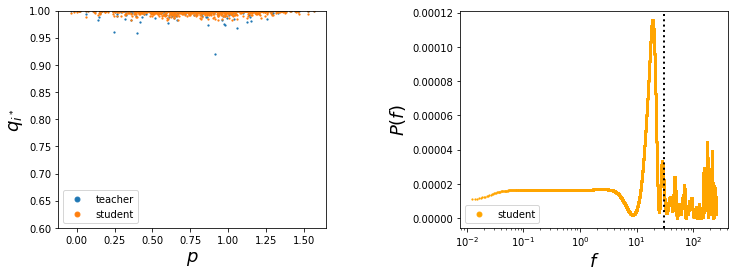

In [13]:
# case 1: unwatermarked case
k = 30.0
xy_match, freqs_match = infer_train_data(epsilon=0.0, k=30.0, N=10, num_points_test=1000, train_part=1,
                                         vec_ind=0, plot_ind=0, num_workers=0,
                                         filename='cl_student.pth', teacher_filename='cl_teacher.pth',
                                         root='demo_models/', path='', teacher_path='', root_data='datasets')

generate_plots_nb(xy_match, freqs_match, k)

Files already downloaded and verified


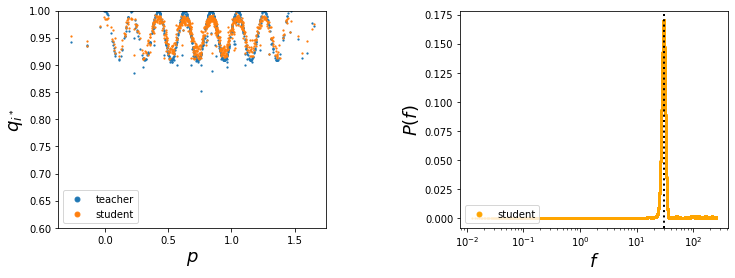

In [14]:
# case 2: watermarked case: matching case, i.e. correct projection vector
k = 30.0
xy_match, freqs_match = infer_train_data(epsilon=0.05, k=30.0, N=10, num_points_test=1000, train_part=1,
                                         vec_ind=0, plot_ind=0, num_workers=0,
                                         filename='wm_student.pth', teacher_filename='wm_teacher.pth',
                                         root='demo_models/', path='', teacher_path='', root_data='datasets')

generate_plots_nb(xy_match, freqs_match, k)

Files already downloaded and verified


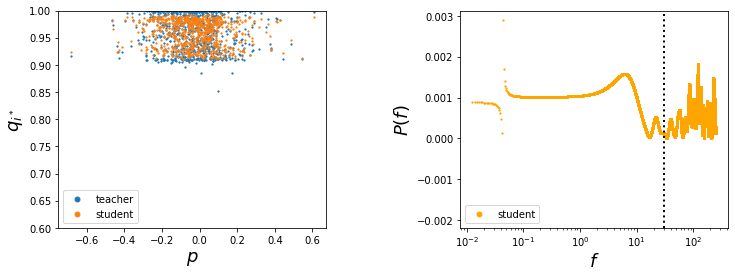

In [15]:
# case 3: watermarked case: nonmatching case, i.e. wrong projection vector
k = 30.0
xy_non_match, freqs_non_match = infer_train_data(epsilon=0.05, k=30.0, N=10, num_points_test=1000, train_part=1,
                                                 vec_ind=0, plot_ind=1, num_workers=0,
                                                 filename='wm_student.pth', teacher_filename='wm_teacher.pth',
                                                 root='demo_models/', path='', teacher_path='', root_data='datasets')

generate_plots_nb(xy_non_match, freqs_non_match, k)

Files already downloaded and verified


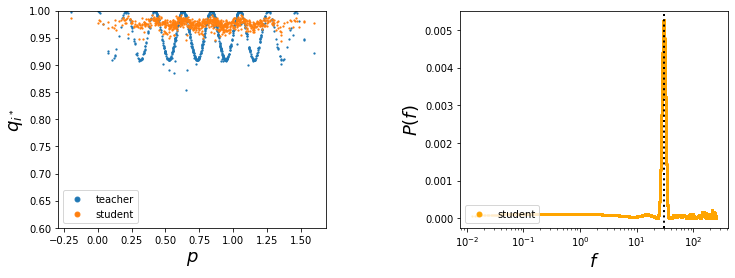

In [16]:
# case 4: watermarked case: distillation from a 2-teacher ensemble, matching case
k = 30.0
xy_match, freqs_match = infer_train_data(epsilon=0.05, k=30.0, N=10, num_points_test=1000, train_part=1,
                                         vec_ind=0, plot_ind=0, num_workers=0,
                                         filename='dist2_student.pth', teacher_filename='wm_teacher.pth',
                                         root='demo_models/', path='', teacher_path='', root_data='datasets')

generate_plots_nb(xy_match, freqs_match, k)